In [17]:
# STEP 1: rename this file to textclassify_model.py

# feel free to include more imports as needed here
# these are the ones that we used for the base model
import random
import numpy as np
import sys
from collections import Counter
import math


"""
Your name and file comment here:
Vedanshi Shah & Byron Pham

"""


"""
Cite your sources here:
"""

"""
Implement your functions that are not methods of the TextClassify class here
"""


def generate_tuples_from_file(training_file_path):
    """
    Generates tuples from file formated like:
    id\ttext\tlabel
    Parameters:
      training_file_path - str path to file to read in
    Return:
      a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
    """
    f = open(training_file_path, "r", encoding="utf8")
    listOfExamples = []
    for review in f:
        if len(review.strip()) == 0:
            continue
        dataInReview = review.split("\t")
        for i in range(len(dataInReview)):
            # remove any extraneous whitespace
            dataInReview[i] = dataInReview[i].strip()
        t = tuple(dataInReview)
        listOfExamples.append(t)
    f.close()
    return listOfExamples


def precision(gold_labels, predicted_labels):
    """
    Calculates the precision for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
        gold_labels (list): a list of labels assigned by hand ("truth")
        predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double precision (a number from 0 to 1)
    """
    # Precision = TruePositives / (TruePositives + FalsePositives)
    true_pos = 0
    false_pos = 0
    for i in range(len(gold_labels)):
        if gold_labels[i] == '1' and predicted_labels[i] == '1':
            true_pos += 1
        elif gold_labels[i] == '0' and predicted_labels[i] == '1':
            false_pos += 1
    if true_pos == 0 and false_pos == 0:
        precision = 0
    else:
        precision = true_pos / (true_pos + false_pos)
    return precision


def recall(gold_labels, predicted_labels):
    """
    Calculates the recall for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
        gold_labels (list): a list of labels assigned by hand ("truth")
        predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double recall (a number from 0 to 1)
    """
    # Recall = TruePositives / (TruePositives + FalseNegatives)
    true_pos = 0
    false_neg = 0
    for i in range(len(gold_labels)):
        if gold_labels[i] == '1' and predicted_labels[i] == '1':
            true_pos += 1
        elif gold_labels[i] == '1' and predicted_labels[i] == '0':
            false_neg += 1
    if true_pos == 0 and false_neg == 0:
        recall = 0
    else:
        recall = true_pos / (true_pos + false_neg)
    return recall


def f1(gold_labels, predicted_labels):
    """
    Calculates the f1 for a set of predicted labels give the gold (ground truth) labels.
    Parameters:
        gold_labels (list): a list of labels assigned by hand ("truth")
        predicted_labels (list): a corresponding list of labels predicted by the system
    Returns: double f1 (a number from 0 to 1)
    """
    # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
    precision_val = precision(gold_labels, predicted_labels)
    recall_val = recall(gold_labels, predicted_labels)
    if precision_val + recall_val == 0:
        f1 = 0
    else:
        f1 = (2 * precision_val * recall_val) / (precision_val + recall_val)
    return f1


def precision_multiclass(gold_labels, classified_labels):
    """ Gold labels is a list of strings of the true labels
        Classified labels is a list of strings of the labels assigned by the classifier
        Returns the precision as a float

    Args:
        gold_labels (list): a list of labels assigned by hand ("truth")
        classified_labels (list): a corresponding list of labels predicted by the system

    Returns:
        double: double precision from 0 to 1
    """
    # Precision = TruePositives / (TruePositives + FalsePositives)
    num_correct = 0
    num_predicted = 0

    # loop through each claass
    for label in set(classified_labels):
        # calculate the number of times this class was predicted
        predicted_count = classified_labels.count(label)
        # calculcate the number of times this class was predicted correctly
        correct_count = sum([1 for i in range(
            len(gold_labels)) if gold_labels[i] == label and classified_labels[i] == label])

        # add to the overall counters
        num_correct += correct_count
        num_predicted += predicted_count

    # calculate the precision
    if num_predicted == 0:
        multi_precision = 0
    else:
        multi_precision = num_correct / num_predicted

    return multi_precision


def recall_multi(gold_labels, classified_labels):
    """gold labels is a list of strings of the true labels
        classified labels is a list of strings of the labels assigned by the classifier
        returns the recall as a float

    Args:
        gold_labels (list): a list of labels assigned by hand ("truth")
        classified_labels (list): a corresponding list of labels predicted by the system

    Returns:
        float: recall as a float
    """
    multiclass_recall = 0
    class_labels = set(gold_labels)
    num_gold = {label: 0 for label in class_labels}
    num_correct = {label: 0 for label in class_labels}

    for gold_label, classified_label in zip(gold_labels, classified_labels):
        num_gold[gold_label] += 1
        if gold_label == classified_label:
            num_correct[gold_label] += 1

    for label in class_labels:
        if num_gold[label] > 0:
            recall += num_correct[label] / num_gold[label]
    multiclass_recall /= len(class_labels)

    return multiclass_recall


def f1_multi(gold_labels, classified_labels):
    """gold labels is a list of strings of the true labels
        classified labels is a list of strings of the labels assigned by the classifier
        returns the f1 as a float

    Args:
        gold_labels (list): a list of labels assigned by hand ("truth")
        classified_labels (list): a corresponding list of labels predicted by the system

    Returns:
        float: f1 as a float
    """
    precision = precision_multiclass(gold_labels, classified_labels)
    recall = recall_multi(gold_labels, classified_labels)
    multi_f1 = 2 * ((precision * recall) / (precision + recall))
    return multi_f1


"""
Implement any other non-required functions here
"""


"""
implement your TextClassify class here
"""


class TextClassify:

    def __init__(self):
        # do whatever you need to do to set up your class here
        self.words_0 = Counter()
        self.words_1 = Counter()

        self.prior_0 = 0
        self.prior_1 = 0

        self.word_data = {0: self.words_0, 1: self.words_1}
        self.vocab = set()

    def train(self, examples):
        """
        Trains the classifier based on the given examples
        Parameters:
          examples - a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
        Return: None
        """
        # TODO: Ask if this should be a self. or not

        # calculate prior for each class
        count_0 = 0
        count_1 = 0
        for example in examples:
            if example[2] == "0":
                count_0 += 1
            else:
                count_1 += 1

        self.prior_0 = count_0 / len(examples)
        self.prior_1 = count_1 / len(examples)

        # update bag of words counts in self.word_data
        # word_data format:
        # { 0: Counter(), 1: Counter() }

        for example in examples:
            words = example[1].split()
            self.vocab.update(words)
            if example[2] == '0':
                self.words_0.update(Counter(words))
            else:
                self.words_1.update(Counter(words))

        self.word_data = {'0': self.words_0, '1': self.words_1}

    def score(self, data):
        """
        Score a given piece of text
        Parameters:
          data - str like "I loved the hotel"
        Return: dict of class: score mappings
        """
        word_probs = {'0': 1, '1': 1}

        word_list = data.split()

        for word in word_list:
            if word in self.words_0:
                word_probs['0'] *= (self.words_0[word] + 1) / \
                    (sum(self.words_0.values()) + len(self.vocab))
            elif word in self.vocab:
                word_probs['0'] *= 1 / \
                    (sum(self.words_0.values()) + len(self.vocab))

            if word in self.words_1:
                word_probs['1'] *= (self.words_1[word] + 1) / \
                    (sum(self.words_1.values()) + len(self.vocab))
            elif word in self.vocab:
                word_probs['1'] *= 1 / \
                    (sum(self.words_1.values()) + len(self.vocab))

        # multiply these by the prior
        word_probs['0'] *= self.prior_0
        word_probs['1'] *= self.prior_1

        return word_probs

    def classify(self, data):
        """
        Label a given piece of text
        Parameters:
          data - str like "I loved the hotel"
        Return: string class label
        """

        score = self.score(data)
        return '0' if score['0'] > score['1'] else '1'

    def featurize(self, data):
        """
        we use this format to make implementation of your TextClassifyImproved model more straightforward and to be
        consistent with what you see in nltk
        Parameters:
          data - str like "I loved the hotel"
        Return: a list of tuples linking features to values
        for BoW, a list of tuples linking every word to True [("I", True), ("loved", True), ("it", True)]
        """

        data_list = data.split()
        return [(d, True) for d in data_list]

    def __str__(self):
        return "Naive Bayes - bag-of-words baseline"


class TextClassifyImproved:
    # count(positive words), count(negative words), 'no' in str,
    # count of 1st and 2nd pronouns, if ! doc, log of length

    def __init__(self):
        self.lexicon = self.read_lexicon('vader_lexicon.txt')
        self.weights = []
        self.theta = {}

    def read_lexicon(self, filepath) -> dict:
        output = {}

        with open(filepath, 'r') as f:
            for line in f:
                l = line.split('\t')
                output[l[0]] = l[1]

        return output

    def k_fold(all_examples, k):
        """"
        all examples is a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
        containing all examples from the train and dev sets

        @return a list of lists containing k sublists where each sublist is one "fold" in the given data
        """

        # shuffle the examples randomly
        random.shuffle(all_examples)

        # split the examples into k folds
        fold_size = len(all_examples) // k
        folds = []
        for i in range(k):
            folds.append(all_examples[i * fold_size:(i + 1) * fold_size])
        return folds

        # # divide the shuffled examples into k folds
        # folds = [all_examples[i::k] for i in range(k)]
        # return folds

    def train(self, examples, epoch, learning_rate):
        """
        Trains the classifier based on the given examples
        Parameters:
          examples - a list of tuples of strings formatted [(id, example_text, label), (id, example_text, label)....]
        Return: None
        """
        docs = [example[1] for example in examples]
        labels = [example[2] for example in examples]

        # featurize the training data
        docs_featurized = [[f[1] for f in self.featurize(doc)] for doc in docs]

        # create a vocabulary from the training data
        # set of all unique words in the training data
        vocab = set()
        for doc in docs:
            vocab.update(doc.split())

        y = [1 if label == '1' else 0 for label in labels]

        # set a flag to use logistic or apply kfold - true or false
        # implements
        # dev_data = self.k_fold(examples, 5)
        # # evaluate the model on the validation data
        # y_true = [example[2] for example in dev_data]
        # y_pred = [self.train_logistic_regression(
        #     example[1]) for example in dev_data]
        # self.true = y_true
        # self.pred = y_pred

        # train the model with logistic regression
        learning_rates = [0.01, 0.1, 1]
        epochs = [10, 50, 100]

        theta_dict = {}
        
        # for lr in learning_rates:
            # for ep in epochs:
        theta = self.train_logistic_regression(docs_featurized, y, learning_rate, epoch)
                # theta_dict[lr, ep] = theta
                
        self.weights = theta
    
        # print(theta_dict)

    def train_logistic_regression(self, x, y, learning_rate=0.001, num_epoch=100):
        # initialise
        n_features = len(x[0])
        theta = np.zeros(n_features)

        # perform gradient descent
        for epoch in range(num_epoch):
            for i in range(len(x)):
                x_i = x[i]  # features
                y_i = y[i]  # label
                h_i = 1/(1 + np.exp(-np.dot(theta, x_i)))  # score
                gradient = np.multiply((h_i - y_i), x_i)
                theta = theta - learning_rate * gradient

        return theta

    def score(self, data):
        """
        Score a given piece of text
        you will compute e ^ (log(p(c)) + sum(log(p(w_i | c))) here
        Parameters:
          data - str like "I loved the hotel"
        Return: dict of class: score mappings
        return a dictionary of the values of P(data | c)  for each class,
        as in section 4.3 of the textbook e.g. {"0": 0.000061, "1": 0.000032}
        """
        features = self.featurize(data)
        assert (len(self.weights) == len(features))
        feature_vals = [f[1] for f in features]

        dot_prod = np.dot(self.weights, feature_vals)
        score = 1 / (1 + math.exp(-1 * dot_prod))
        return score

    def classify(self, data):
        """
        Label a given piece of text
        Parameters:
          data - str like "I loved the hotel"
        Return: string class label
        """
        prob = self.score(data)
        return '0' if prob <= 0.5 else '1'

    def featurize(self, data):
        """
        we use this format to make implementation of this class more straightforward and to be
        consistent with what you see in nltk
        Parameters:
          data - str like "I loved the hotel"
        Return: a list of tuples linking features to values
        for BoW, a list of tuples linking every word to True [("I", True), ("loved", True), ("it", True)]
        """
        # features = [pos_words, neg_words, num_nos,
        #             num_1_and_2, num_exclam, log_length]

        features = [0, 0, 0, 0, 0, 0]

        features[5] = math.log(len(data.split()))
        features[4] = data.count('!')

        for word in data.split():
            if word in self.lexicon:
                if float(self.lexicon[word]) > 0:
                    features[0] += 1
                elif float(self.lexicon[word]) < 0:
                    features[1] += 1
            if word.lower() == 'no':
                features[2] += 1
            if word.lower() in [
                'me', 'i', 'my', 'myself', 'mine',
                'we', 'us', 'our', 'ourselves', 'ours',
                'you', 'your', 'yourself', 'yourselves'
            ]:
                features[3] += 1

        return [
            ('pos_words', features[0]),
            ('neg_words', features[1]),
            ('num_nos', features[2]),
            ('num_1_2_pronouns', features[3]),
            ('num_exclm', features[4]),
            ('log_length', features[5]),
            ('bias', 1)
        ]

    def __str__(self):
        return "Logistic Regression Classifier"

    def describe_experiments(self):
        s = """
    Description of your experiments and their outcomes here.
    """

        return s


training = 'training_files/movie_reviews_train.txt'
testing = 'training_files/movie_reviews_dev.txt'

classifier = TextClassify()
print(classifier)
# do the things that you need to with your base class
examples_train_base = generate_tuples_from_file(training)
classifier.train(examples_train_base)
examples_dev_base = generate_tuples_from_file(testing)
y_labels = [e[2] for e in examples_dev_base]
y_pred = []
for example in examples_dev_base:
    y_pred.append(classifier.classify(example[1]))

# report precision, recall, f1
base_precision = precision(y_labels, y_pred)
base_recall = recall(y_labels, y_pred)
base_f1 = f1(y_labels, y_pred)

print(f'Base precision: {base_precision}')
print(f'Base recall: {base_recall}')
print(f'Base f1: {base_f1}')

# -------------------------------------------------------------------------
# Improved model
improved = TextClassifyImproved()
print(improved)

# do the things that you need to with your improved class
examples_train = generate_tuples_from_file(training)
learning_rate = [0.0001, 0.002, 0.005, 0.001]
epochs = [50, 100, 150, 500]
import pandas as pd
lr_list = []
epoch_list = []
prec_lst = []
rec_lst = []
f1_lst = []
df = pd.DataFrame(columns=['learning_rate', 'epochs', 'precision', 'recall', 'f1'])
i = 0
for lr in learning_rate:
    for ep in epochs:
        print(f'LEARNING RATE: {lr}')
        print(f'EPOCHS: {ep}')
        lr_list.append(lr)
        epoch_list.append(ep)
        improved.train(examples_train, ep, lr)
        print(f'LEARNED WEIGHTS: {improved.weights}')

        examples_dev = generate_tuples_from_file(testing)
        y_labels = [e[2] for e in examples_dev]
        y_pred = []
        for example in examples_dev:
            y_pred.append(improved.classify(example[1]))

        # report a summary of your experiments/features here
        print(improved.describe_experiments())

        # report final precision, recall, f1 (for your best model)
        # precision = tp / (tp+fp)
        final_precision = precision(y_labels, y_pred)
        prec_lst.append(final_precision)
        # recall = tp / (tp+fn)
        final_recall = recall(y_labels, y_pred)
        rec_lst.append(final_recall)
        # f1 = 2 * (precision * recall) / (precision + recall)
        final_f1 = f1(y_labels, y_pred)
        f1_lst.append(final_f1)

        print(f'FINAL PRECISION: {final_precision}')
        print(f'FINAL RECALL: {final_recall}')
        print(f'FINAL F1: {final_f1}')
        df.loc[i] = [lr, ep, final_precision, final_recall, final_f1]
        i+=1
        print('-------------------------------------------------')

Naive Bayes - bag-of-words baseline
Base precision: 0.553763440860215
Base recall: 0.9809523809523809
Base f1: 0.7079037800687284
Logistic Regression Classifier
LEARNING RATE: 0.0001
EPOCHS: 50
LEARNED WEIGHTS: [ 0.14328484 -0.18776618 -0.04112838 -0.01828445 -0.00435504 -0.01503128
  0.00458965]

    Description of your experiments and their outcomes here.
    
FINAL PRECISION: 0.7027027027027027
FINAL RECALL: 0.7428571428571429
FINAL F1: 0.7222222222222223
-------------------------------------------------
LEARNING RATE: 0.0001
EPOCHS: 100
LEARNED WEIGHTS: [ 0.14338049 -0.18691384 -0.05432421 -0.01815834 -0.00442221 -0.01648799
  0.01139621]

    Description of your experiments and their outcomes here.
    
FINAL PRECISION: 0.7027027027027027
FINAL RECALL: 0.7428571428571429
FINAL F1: 0.7222222222222223
-------------------------------------------------
LEARNING RATE: 0.0001
EPOCHS: 150
LEARNED WEIGHTS: [ 0.14346046 -0.18648903 -0.06036364 -0.01808562 -0.00445556 -0.01796295
  0.018120

In [19]:
df

,learning_rate,epochs,precision,recall,f1
0,0.0001,50.0,0.702703,0.742857,0.722222
1,0.0001,100.0,0.702703,0.742857,0.722222
2,0.0001,150.0,0.702703,0.742857,0.722222
3,0.0001,500.0,0.702703,0.742857,0.722222
4,0.0020,50.0,0.769231,0.666667,0.714286
5,0.0020,100.0,0.769231,0.666667,0.714286
6,0.0020,150.0,0.769231,0.666667,0.714286
7,0.0020,500.0,0.775281,0.657143,0.711340
8,0.0050,50.0,0.753425,0.523810,0.617978
9,0.0050,100.0,0.756757,0.533333,0.625698


In [21]:
df['f1'].idxmax()

12

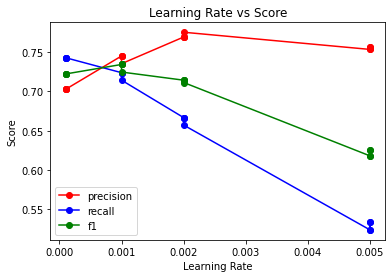

In [22]:
import matplotlib.pyplot as plt
# include epochs in the plot
df.sort_values(by=['learning_rate'], inplace=True)
plt.plot(df['learning_rate'], df['precision'], label='precision', marker='o', color='red')
plt.plot(df['learning_rate'], df['recall'], label='recall', marker='o', color='blue')
plt.plot(df['learning_rate'], df['f1'], label='f1', marker='o', color='green')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Learning Rate vs Score')
plt.show()

In [23]:
# clean the yelp data
import pandas as pd

df_yelp = pd.read_csv('training_files/yelp.csv')
df_yelp.head()
df_yelp = df_yelp[['user_id', 'text', 'stars']]
df_yelp.to_csv('training_files/yelp.txt', index=False)

# make sure the text column is clean and in one line
df_yelp['text'] = df_yelp['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

# get the first 800 reviews as training data
df_yelp_train = df_yelp[:800]
df_yelp_train.to_csv('training_files/yelp_train.txt', index=False, sep='\t')

# get the last 200 reviews as testing data
df_yelp_test = df_yelp[800:]
df_yelp_test.to_csv('training_files/yelp_test.txt', index=False, sep='\t')